<a href="https://colab.research.google.com/github/bbogdanovaalina/persistent-laplacian/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_(1_%D0%B2%D0%B0%D1%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tqdm
import os

In [ ]:
!mkdir class_0

In [ ]:
!mkdir class_1

In [2]:
class_0 = "./class_0/"
class_1 = "./class_1/"

In [3]:
!mv sub* class_0

mv: cannot stat 'sub*': No such file or directory


In [4]:
n_oper = 25

In [5]:
df = []

In [6]:
def str_to_arr(s):
    if len(s) == 2:
        return [np.nan]
    return [float(x) for x in s[1:-1].split(", ")]

In [7]:
def add_moments():
    df = []
    fl = 0
    for cls in [class_0, class_1]:
        for filename in os.listdir(cls):
            cur_line = pd.read_csv(cls + filename, names=("A", "B", "C", "Spec"))
    
            #ev = eigen values
            cur_mean_ev = [0] * n_oper
            cur_var_ev = [0] * n_oper
    
            for i in range(n_oper):
                try:
                    fl = 0
                    cur_mean_ev[i] = np.mean(str_to_arr(cur_line.loc[i, "Spec"]))
                    cur_var_ev[i] = np.var(str_to_arr(cur_line.loc[i, "Spec"]))
                except KeyError as e:
                    fl = 1
                    print(e, filename)
                    break
                except AttributeError as e:
                    fl = 1
                    print(e, filename)
                    break
    
            if not fl:
                df.append(cur_mean_ev + cur_var_ev + [1 if cls == class_1 else 0])
    return df

In [8]:
df = add_moments()

In [9]:
def trim_specs(spec_len=5):
    df = []
    fl = 0
    for cls in [class_0, class_1]:
        for filename in os.listdir(cls):
            cur_line = pd.read_csv(cls + filename, names=("A", "B", "C", "Spec"))

            #ev = eigen values
            cur_specs = []
            for i in range(n_oper):
                try:
                    fl = 0
                    cur_spec = str_to_arr(cur_line.loc[i, "Spec"])
                    trimmed_spec = sorted(cur_spec)[:spec_len]
                    
                    while len(trimmed_spec) < spec_len:
                        trimmed_spec.append(trimmed_spec[-1])
                        
                    cur_specs.extend(trimmed_spec)
                except KeyError as e:
                    fl = 1
                    print(e, filename)
                    break
                except AttributeError as e:
                    fl = 1
                    print(e, filename)
                    break
            
            if not fl:
                df.append(cur_specs + [1 if cls == class_1 else 0])

    return df

In [10]:
df_trim = trim_specs()

In [25]:
def mymetric(x, y, spec_len=5):
    ans = 0
    c = spec_len
    while c < len(x):
        ans += wasserstein_distance(x[c-spec_len:c], y[c-spec_len:c])
        c += spec_len
    
    return ans

In [23]:
def make_data(spec_len=5, test = 0.3):
    df_trim = pd.DataFrame(
        trim_specs(spec_len)
    )

    # Set small non-zero elements to zero
    df_trim[df_trim.abs() < 1e-10] = 0

    X = df_trim.iloc[:, :-1]
    y = df_trim.iloc[:, -1]
    X.fillna(X.mean(axis=0), inplace=True)
    #X = RobustScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=76, test_size=test)

    return X_train, X_test, y_train, y_test

In [26]:
def plot_knn(n_min=3, n_max=10, spec_len=5):
    acc = []
    for n_neigh in tqdm.trange(n_min, n_max):
        knn = KNeighborsClassifier(
            n_neighbors=n_neigh,
            metric=mymetric, 
            metric_params={"spec_len": spec_len}
            )
        knn.fit(X_train, y_train)
        acc.append(accuracy_score(y_test, knn.predict(X_test)))

    fig, axes = plt.subplots()
    axes.set_ylabel("accuracy")
    axes.set_xlabel("n_neighbors")

    axes.plot(range(n_min, n_max), acc)

    return acc

In [ ]:
#df_trim.to_csv("5trim_spec.csv", header=False)

In [ ]:
missing_ops = list(df.columns[df.isna().sum() < 50])
#missing_ops = []

In [15]:
spec_len = 5

In [16]:
X_train, X_test, y_train, y_test = make_data(spec_len=spec_len)

In [20]:
len(X_train), len(X_test)

(504, 216)

100%|██████████| 10/10 [12:46<00:00, 76.69s/it]


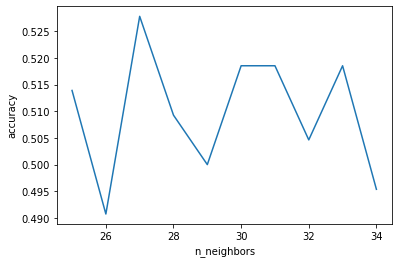

In [17]:
acc = plot_knn(25, 35, spec_len=spec_len) #32


100%|██████████| 10/10 [12:38<00:00, 75.85s/it]


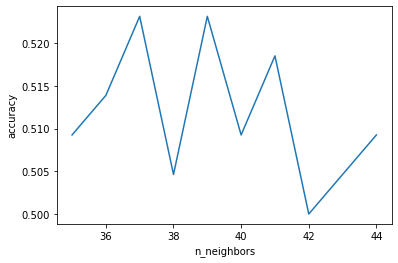

In [18]:
acc = plot_knn(35, 45, spec_len=spec_len)

In [ ]:
acc = plot_knn(25, 35, spec_len=spec_len)

[0.5930232558139535]

In [ ]:
knn = KNeighborsClassifier(
            n_neighbors=33,
            metric=mymetric, 
            metric_params={"spec_len": spec_len}
            )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
a = accuracy_score(y_test, y_pred)


In [ ]:
conf = confusion_matrix(y_test, y_pred)

In [ ]:
a

0.5277777777777778

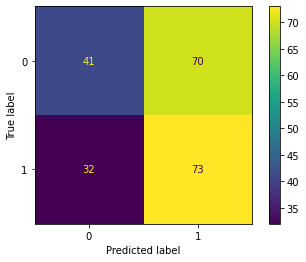

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
acc

[0.5930232558139535]

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
y_pred_lr = lr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_lr)

0.48148148148148145

In [24]:
X_train, X_test, y_train, y_test = make_data(spec_len=spec_len, test=0.2)

100%|██████████| 10/10 [09:37<00:00, 57.74s/it]


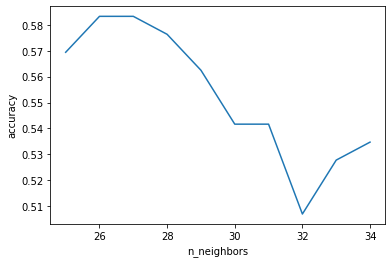

In [27]:
acc_02 = plot_knn(25, 35, spec_len=spec_len)

100%|██████████| 10/10 [09:39<00:00, 57.99s/it]


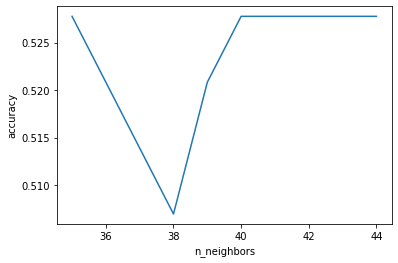

In [28]:
acc_02 = plot_knn(35, 45, spec_len=spec_len)

100%|██████████| 10/10 [09:36<00:00, 57.67s/it]


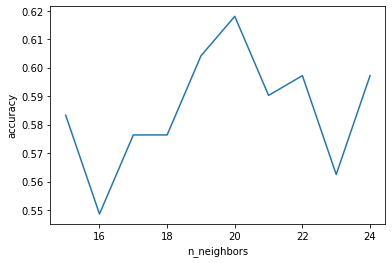

In [29]:
acc_02 = plot_knn(15, 25, spec_len=spec_len)

0.6180555555555556


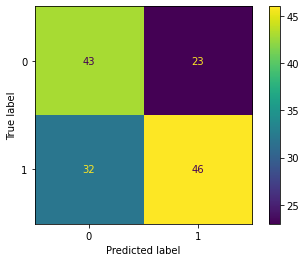

In [32]:
knn = KNeighborsClassifier(
            n_neighbors=20,
            metric=mymetric, 
            metric_params={"spec_len": spec_len}
            )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

0.5833333333333334


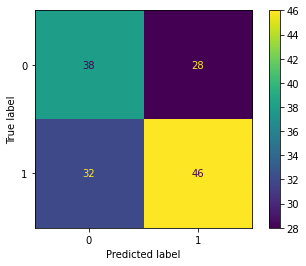

In [34]:
knn = KNeighborsClassifier(
            n_neighbors=26,
            metric=mymetric, 
            metric_params={"spec_len": spec_len}
            )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [42]:
from scipy.spatial import distance
import seaborn as sns

In [ ]:
df_trim = pd.DataFrame(trim_specs(spec_len))
dist_matrix_all = distance.pdist(df_trim.iloc[:, :-1], metric=mymetric)
dist_matrix_sq_all = distance.squareform(dist_matrix_all, force='no', checks=True)


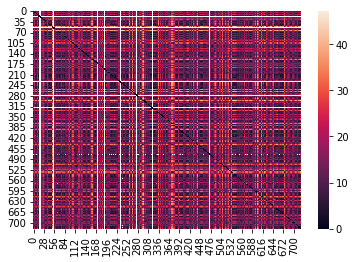

In [43]:
sns.heatmap(dist_matrix_sq_all)

In [65]:
gb = GradientBoostingClassifier(n_estimators=95)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
accuracy_score(y_test, y_pred_gb)

0.6111111111111112

In [64]:
gb = GradientBoostingClassifier(n_estimators=120)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
accuracy_score(y_test, y_pred_gb)

0.6319444444444444

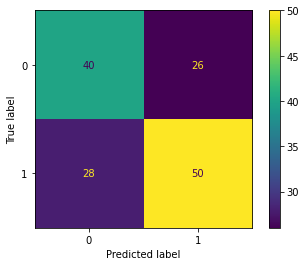

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb)

In [61]:
gb = GradientBoostingClassifier(n_estimators=150)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
accuracy_score(y_test, y_pred_gb)

0.6180555555555556

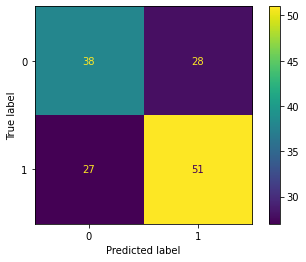

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb)

In [68]:
np.logspace(-3, -0.5, 10)

array([0.001     , 0.00189574, 0.00359381, 0.00681292, 0.0129155 ,
       0.02448437, 0.04641589, 0.08799225, 0.16681005, 0.31622777])

In [84]:
gs = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid={
        "loss": ["exponential"],
        "learning_rate": np.logspace(-2, -0.5, 10),
        'n_estimators': np.array([40])
    },
    cv=5,
    scoring="accuracy",
)

In [85]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01      , 0.01467799, 0.02154435, 0.03162278, 0.04641589,
       0.06812921, 0.1       , 0.14677993, 0.21544347, 0.31622777]),
                         'loss': ['exponential'], 'n_estimators': array([40])},
             scoring='accuracy')

In [79]:
y_pred_gs = gs.predict(X_test)

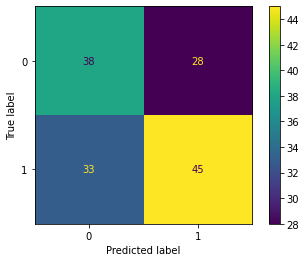

In [81]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gs)

In [83]:
accuracy_score(y_test, y_pred_gs)

0.5763888888888888

In [88]:
def make_data_moments(test = 0.3):
    df = add_moments()

    X = np.array([i[:-1] for i in df])
    y = [i[-1] for i in df]
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])
    #X.fillna(X.mean(axis=0), inplace=True)
    #X = RobustScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=76, test_size=test)

    return X_train, X_test, y_train, y_test

In [105]:
 X_train, X_test, y_train, y_test = make_data_moments(test=0.2)

In [115]:
def plot_knn_moments(n_min=3, n_max=10):
    acc = []
    rec = []
    for n_neigh in tqdm.trange(n_min, n_max):
        knn = KNeighborsClassifier(
            n_neighbors=n_neigh,
            )
        knn.fit(X_train, y_train)
        acc.append(accuracy_score(y_test, knn.predict(X_test)))
        rec.append(recall_score(y_test, knn.predict(X_test)))

    fig, axes = plt.subplots()
    axes.set_ylabel("accuracy")
    axes.set_xlabel("n_neighbors")
    
    axes.plot(range(n_min, n_max), acc, color='red')
    axes.plot(range(n_min, n_max), rec, color='blue')
    return acc, rec

100%|██████████| 40/40 [00:02<00:00, 19.26it/s]


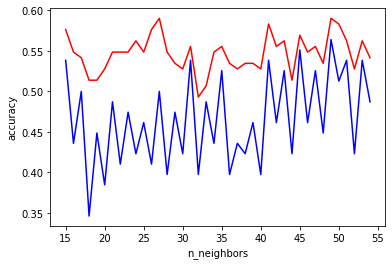

In [116]:
acc_moments = plot_knn_moments(15, 55)

In [ ]:
def collect_specs(n_oper=25, test_cap=None):
    df = []
    avg_mean = np.zeros(n_oper)
    avg_len = np.zeros(n_oper)

    
    for cls in [class_0, class_1]:
        line_cnt = 0
        for filename in os.listdir(cls):
            cur_line = pd.read_csv(cls + filename, header=None)
            cur_num_spec = []
            i = 0
            for spec_str in cur_line[3]:
                num_spec = str_to_arr(spec_str)
                cur_num_spec.append(num_spec)

                if len(num_spec):
                    avg_mean[i] += sum(num_spec) / len(num_spec)
                    avg_len[i] += len(num_spec)
                # print(sum(num_spec))
                i += 1

            df.append(cur_num_spec + [1 if cls == class_1 else 0])
            if test_cap:
                line_cnt += 1
                if line_cnt >= test_cap:
                    
                    break

    return df, avg_mean / len(df), avg_len / len(df)

In [ ]:
n_data=500

In [ ]:
df, avg_mean, avg_len = collect_specs(test_cap=n_data)

In [ ]:
def make_data(test_cap=n_data, test = 0.2):
    df, avg_mean, avg_len = collect_specs(test_cap=n_data)
    fill_na(df, avg_mean, avg_len)
    X_train, X_test, y_train, y_test = train_test_split([spec_list[:-1] for spec_list in df], [spec_list[-1] for spec_list in df], test_size=test)

    return X_train, X_test, y_train, y_test

In [ ]:
def fill_na(df, avg_mean, avg_len, deg_freedom=1):
    for spec_list in df:
        for i in range(n_oper):
            #print(spec_list[i])
            if not len(spec_list[i]):
                spec_list[i] = (np.random.chisquare(deg_freedom, int(avg_len[i])) * avg_mean[i]).tolist()
    return df

In [ ]:
fill_na(df, avg_mean, avg_len)

In [ ]:
def check_na(df):
    cnt = 0
    for spec_list in df:
        if [] in spec_list:
            cnt += 1

    return cnt

check_na(df)

0

In [ ]:
def wmetr(x, y):
    # x, y: python lists of python lists
    ans = 0
    for (u, v) in zip(x, y):
        ans += wasserstein_distance(u, v)

    return ans

In [ ]:
# The last entry is the class
wmetr(df[0][:-1], df[1][:-1])

29.169481178899755

In [ ]:
X_train, X_test, y_train, y_test = make_data(test_cap=n_data)

In [ ]:
len(X_test)

180

In [ ]:
class MyKNN:
    def __init__(self, X_train, y_train, n=30):
        self.n = n
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, x):
        y_pred = 0

        dist = [(wmetr(x_train, x), y_tr) for (x_train, y_tr) in zip(self.X_train, self.y_train)]
        nearest = sorted(dist, key=lambda el: el[0])[:self.n]
        
        y_pred = int(sum(el[1] for el in nearest) / self.n)

        return y_pred

In [ ]:
acc = []

for n in tqdm.trange(3, 50, 3):
    knn = MyKNN(X_train, y_train, n)
    y_pred = [knn.predict(x_test) for x_test in X_test]
    cur_acc = accuracy_score(y_test, y_pred)
    acc.append(cur_acc)

100%|██████████| 16/16 [46:50<00:00, 175.67s/it]


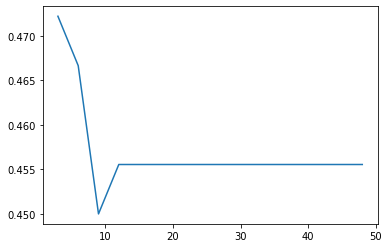

In [ ]:
plt.plot(range(3, 50, 3), acc)

In [ ]:
X_train, X_test, y_train, y_test = make_data(test_cap=n_data)

In [ ]:
len(y_test)

144

In [ ]:
acc_02 = []

for n in tqdm.trange(3, 30, 3):
    knn = MyKNN(X_train, y_train, n)
    y_pred = [knn.predict(x_test) for x_test in X_test]
    cur_acc = accuracy_score(y_test, y_pred)
    acc.append(cur_acc)

100%|██████████| 9/9 [22:36<00:00, 150.70s/it]


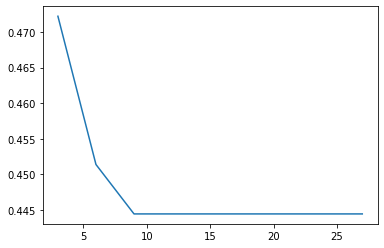

In [ ]:
plt.plot(range(3, 30, 3), acc[-9:])

In [ ]:
class_0 = "./class_0/"
class_1 = "./class_1/"

n_oper = 25

df = []

def str_to_arr(s):
    if len(s) == 2:
        return [0]
    return [float(x) for x in s[1:-1].split(", ")]

def get_specs_pat():
    df = []
    fl = 0
    for cls in [class_1]:
        for filename in os.listdir(cls):
            if filename != '.ipynb_checkpoints':
                cur_line = pd.read_csv(cls + filename,names=("Spec"))# names=("A", "B", "C", "Spec"))

                cur_specs = [[] for i in range(n_oper)]
                for i in range(n_oper):
                    try:
                        fl = 0
                                                                            
                        cur_specs[i] = np.array(str_to_arr(cur_line.loc[i, "Spec"])) #/ np.sum(np.array(str_to_arr(cur_line.loc[i, "Spec"])))

                    except KeyError as e:
                        fl = 1
                        print(e, filename)
                        break
                    except AttributeError as e:
                        fl = 1
                        print(e, filename)
                        break
                
                if not fl:
                    df.append(cur_specs + [1])

    return df

def get_specs_con():
    df = []
    fl = 0
    for cls in [class_0]:
        for filename in os.listdir(cls):
            if filename != '.ipynb_checkpoints':
                cur_line = pd.read_csv(cls + filename, names=("Spec"))# names=("A", "B", "C", "Spec"))

                #ev = eigen values
                cur_specs = [[] for i in range(n_oper)]
                for i in range(n_oper):
                    try:
                        fl = 0
                                                                            
                        cur_specs[i] = np.array(str_to_arr(cur_line.loc[i, "Spec"])) #/ np.sum(np.array(str_to_arr(cur_line.loc[i, "Spec"])))

                    except KeyError as e:
                        fl = 1
                        print(e, filename)
                        break
                    except AttributeError as e:
                        fl = 1
                        print(e, filename)
                        break
                
                if not fl:
                    df.append(cur_specs + [0])

    return df
def get_specs():
    df = []
    fl = 0
    for cls in [class_0, class_1]:
        for filename in os.listdir(cls):
            if filename != '.ipynb_checkpoints':
                cur_line = pd.read_csv(cls + filename,names=("Spec"))# names=("A", "B", "C", "Spec"))

                #ev = eigen values
                cur_specs = [[] for i in range(n_oper)]
                for i in range(n_oper):
                    try:
                        fl = 0
                                                                            
                        cur_specs[i] = np.array(str_to_arr(cur_line.loc[i, "Spec"])) #/ np.sum(np.array(str_to_arr(cur_line.loc[i, "Spec"])))

                    except KeyError as e:
                        fl = 1
                        print(e, filename)
                        break
                    except AttributeError as e:
                        fl = 1
                        print(e, filename)
                        break
                
                if not fl:
                    df.append(cur_specs + [1 if cls == class_1 else 0])

    return np.array(df)


def str_to_arr(s):
    if len(s) == 2:
        return [0]
    return [float(x) for x in s[1:-1].split(", ")]

In [ ]:
get_specs()

In [ ]:
def mymetric_1(x, y):
    ans = 0
    #print(x, y)
    for i in range(n_oper):
        ans += wasserstein_distance(x[i], y[i]) #/ (np.sum(x[i]) + 0.0000001) / (np.sum(y[i]) + 0.0000001)
    return ans

In [ ]:
df_all = get_specs()
df_con = get_specs_con()
df_pat = get_specs_pat()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


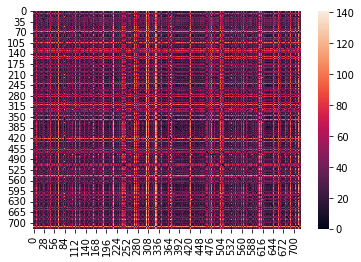

In [ ]:
dist_matrix_all = distance.pdist(df_all, metric=mymetric_1)
dist_matrix_sq_all = distance.squareform(dist_matrix_all, force='no', checks=True)
sns.heatmap(dist_matrix_sq_all)


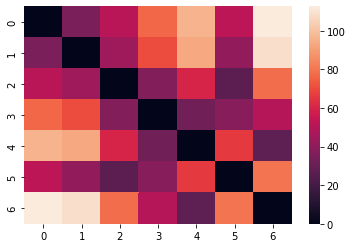

In [ ]:
dist_matrix_all_1 = distance.pdist(df_all[[np.random.randint(-50, 0), np.random.randint(-50, 0),np.random.randint(-50, 0),np.random.randint(0, 50),np.random.randint(0, 50),np.random.randint(0, 50),np.random.randint(0, 50),]], metric=mymetric_1)
dist_matrix_sq_all_1 = distance.squareform(dist_matrix_all_1, force='no', checks=True)
sns.heatmap(dist_matrix_sq_all_1)
#print(dist_matrix_sq_all)

Text(33.0, 0.5, 'Здоровые           Больные')

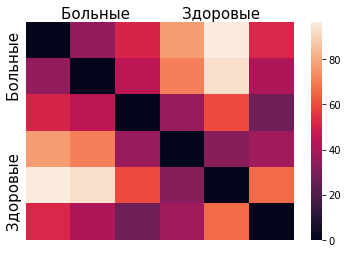

In [ ]:
ax = sns.heatmap(dist_matrix_sq_all_1[:6, :6])
#plt.title('Матрица расстояний между спектрами трех случайных больных и трех случайных здоровых людей', fontsize = 10)
ax.xaxis.set_label_position('top')

ax.set_xticks([]) 
ax.set_yticks([])
plt.xlabel('Больные           Здоровые', fontsize = 15) 
plt.ylabel('Здоровые           Больные', fontsize = 15)

In [ ]:
def make_data():
    df_trim = pd.DataFrame(
        trim_specs(spec_len)
    )

    # Set small non-zero elements to zero
    df_trim[df_trim.abs() < 1e-12] = 0

    X = df_trim.iloc[:, :-1]
    y = df_trim.iloc[:, -1]
    X.fillna(X.mean(axis=0), inplace=True)
    X = RobustScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.7)

    return X_train, X_test, y_train, y_test

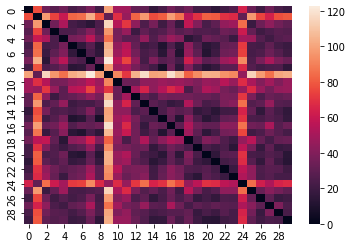

In [ ]:
dist_matrix_all_1 = distance.pdist(df_all[np.arange(-15, 15)], metric=mymetric_1)
dist_matrix_sq_all_1 = distance.squareform(dist_matrix_all_1, force='no', checks=True)
sns.heatmap(dist_matrix_sq_all_1)
#print(dist_matrix_sq_all)

In [ ]:
np.mean(dist_matrix_sq_all[377:, :377])

41.672620493192824

In [ ]:
dist_matrix_pat = distance.pdist(df_pat, metric=mymetric_1)
#dist_matrix_sq_ = distance.squareform(dist_matrix_all, force='no', checks=True)
#sns.heatmap(dist_matrix_sq_all)
np.mean(dist_matrix_pat)

/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


42.10977591904334

In [ ]:
dist_matrix_con = distance.pdist(df_con, metric=mymetric_1)
#dist_matrix_sq_ = distance.squareform(dist_matrix_all, force='no', checks=True)
#sns.heatmap(dist_matrix_sq_all)
np.mean(dist_matrix_con)

/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


40.99650518936351

In [ ]:
def mymetric_1_ind(x, y, ind=8):
    return wasserstein_distance(x[ind], y[ind])

dist_matrix_1_3 = distance.pdist(new_df, metric=mymetric_1_ind)
dist_matrix_sq_1_3 = distance.squareform(dist_matrix_1_3, force='no', checks=True)
sns.heatmap(dist_matrix_sq_1_3)

In [ ]:
np.shape(df_pat)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(377, 26)

In [ ]:
def mymetric_1(x, y):
    ans = 0
    for i in range(n_oper):
        ans += wasserstein_distance(x[i], y[i])
    return ans

/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


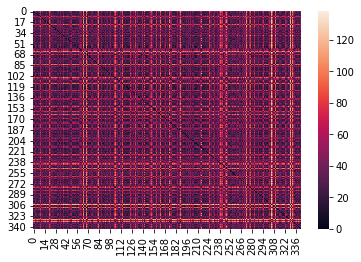

In [ ]:
dist_matrix_con = distance.pdist(df_con, metric=mymetric_1)
dist_matrix_sq_con = distance.squareform(dist_matrix_con, force='no', checks=True)
sns.heatmap(dist_matrix_sq_con)

/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


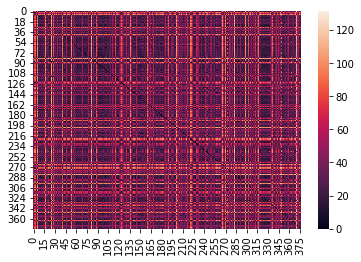

In [ ]:
dist_matrix_pat = distance.pdist(df_pat, metric=mymetric_1)
dist_matrix_sq_pat = distance.squareform(dist_matrix_pat, force='no', checks=True)
sns.heatmap(dist_matrix_sq_pat)

In [ ]:
df_all = get_specs()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


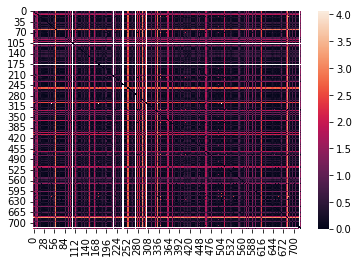

In [ ]:
dist_matrix_all = distance.pdist(df_all, metric=mymetric_1)
dist_matrix_sq_all = distance.squareform(dist_matrix_all, force='no', checks=True)
sns.heatmap(dist_matrix_sq_all)

In [ ]:
def mymetric_2(x, y):
  return wasserstein_distance(x[0], y[0])

/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


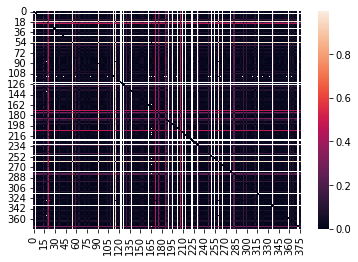

In [ ]:
dist_matrix_pat_2 = distance.pdist(df_pat, metric=mymetric_2)
dist_matrix_sq_pat_2 = distance.squareform(dist_matrix_pat_2, force='no', checks=True)
sns.heatmap(dist_matrix_sq_pat_2)

/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


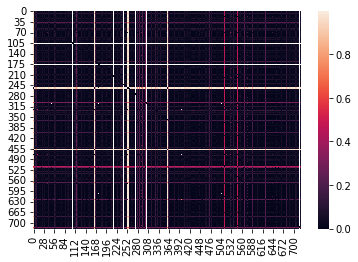

In [ ]:
dist_matrix_all_2 = distance.pdist(df_all, metric=mymetric_2)
dist_matrix_sq_all_2 = distance.squareform(dist_matrix_all_2, force='no', checks=True)
sns.heatmap(dist_matrix_sq_all_2)

In [ ]:
dl = []
for i in range(len(dist_matrix_sq_pat_2)):
  k = 0
  for j in range(len(dist_matrix_sq_pat_2)):
    if dist_matrix_sq_pat_2[i][j] > 0.5:
      k += 1
  if k > 10:
    dl.append(i)
dl


[18, 55, 92, 116, 261]

In [ ]:
print(np.mean(dist_matrix_pat), np.mean(dist_matrix_con))

42.10977591904334 40.99650518936351
